In [1]:
"""this notebook demonstrates how our dag optimisation
can on it's own come up with good task allocation 
schemes for two opposing types of tasks
1)obvious benefit to edge-device computing
2)no benefit in edge-device computing"""
import sys
sys.path.append('../')
from app.dag_solver import solve_DAG
from app.visualiser import plotgraph
import matplotlib.pyplot as plt
import itertools
import math
import functools
import collections

Network Characteristics
=========

* 12 node network including server and 2 other routers
* Each edge node connected to one router. routers connected to all other routers also.
* Homogenous processor speed 5% of server
* Homogenous link strength of -50dB

In [2]:
J = {0:{1:500}, 1:{2:500}, 2: {0:500, 3:500}, 3:{1:400}}
def chunk(lst, num_chunks):
    chunk_size = math.ceil(len(lst)/num_chunks)
    chunks = (list(itertools.islice(lst, x, x+chunk_size))
              for x in range(0, len(lst), chunk_size))
    return list(chunks)
def lst_to_dict(lst):
    return {k:-50 for k in lst}
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z
def assign_edge(edges, routers, degree):
    num_buckets = len(routers)
    chunks = chunk(edges, num_buckets)
    adjacency = {k:[] for k in edges}
    bucketiser = functools.partial(buckets, num_buckets,degree)
    idx_to_node = functools.partial(translater,routers)
    for chk in chunks:
        for node in chk:
            adjacency[node]+=idx_to_node(bucketiser(node))
    return {k:lst_to_dict(v) for k,v in adjacency.items()}
def mirror(d):
    new_d = collections.defaultdict(dict)
    for k,v in d.items():
        for node, weight in v.items():
            new_d[k][node] = weight
            new_d[node][k] = weight
    return new_d
def translater(lst, idxs):
    return [lst[i] for i in idxs]
def buckets(num_buckets, degree, idx):
    return [(idx+offset)%num_buckets for offset in range(degree)]
def create_network(routers, edges, edge_degree):
    def adjacent(node, possibles):
        return {k:-50 for k in possibles if k!=node}
    router_net = assign_edge(routers, routers, 2)
    edge_to_router = assign_edge(edges, routers, edge_degree)
    return merge_two_dicts(router_net, edge_to_router)
rssi = create_network(range(3), range(3,12),1)
processor = {k:1 if k==0 else 0.05 for k in range(len(rssi))}

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


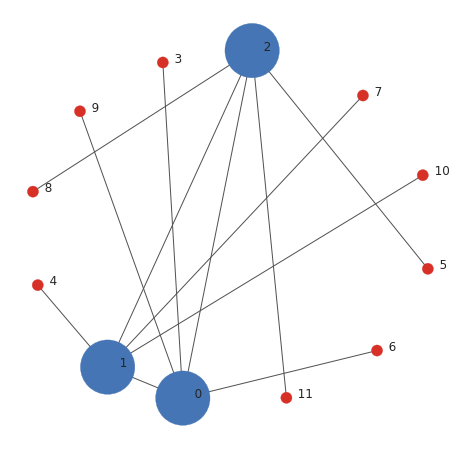

In [3]:
fig, ax = plotgraph(rssi)
plt.show()
fig.savefig('graph_one', dpi=450)

Scenario 1
==========
collect 1/2 second triaxial data at each node in network.

then find average for each axis and concatenate results

In [4]:
code = """class SenseReduce:
    def __init__(self):
        self.sensenodes = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]
        self.mapnodes =   [ [0,1,2],[0,1,2]
                           ,[0,1,2,3],[0,1,2,4],[0,1,2,5]
                           ,[0,1,2,6],[0,1,2,7],[0,1,2,8]
                           ,[0,1,2,9],[0,1,2,10],[0,1,2,11]]
        self.reducenodes = [[0,1,2,3]]
    def sampler(self,node):
        acc = yield from node.accel(2000) ###a lot of data
        return acc
    def mapper(self,node,d):
        import time
        avgs = {k: round(sum(v)/len(v),2) 
                for k,v in d.items()} #just avg
        yield(node.ID,avgs)#a much smaller amount of data
    def reducer(self,node,k,vs):
        yield(k,vs) #no reduction from map"""
solution, time = solve_DAG(code, mirror(rssi), processor)
print('solution: ', solution, time)

weights:  {'M': {0: {'edge': {0: 44}, 'cost': 0.19860267639160156}, 1: {'edge': {0: 41}, 'cost': 0.17118453979492188}, 2: {'edge': {0: 41}, 'cost': 0.1628398895263672}, 3: {'edge': {0: 44}, 'cost': 0.1697540283203125}, 4: {'edge': {0: 44}, 'cost': 0.1800060272216797}, 5: {'edge': {0: 42}, 'cost': 0.4031658172607422}, 6: {'edge': {0: 45}, 'cost': 0.1926422119140625}, 7: {'edge': {0: 43}, 'cost': 0.17070770263671875}, 8: {'edge': {0: 43}, 'cost': 0.17189979553222656}, 9: {'edge': {0: 44}, 'cost': 0.1575946807861328}, 10: {'edge': {0: 46}, 'cost': 0.15735626220703125}}, 'S': {0: {'edge': {0: 123089}, 'cost': 2007.7820375384347}, 1: {'edge': {1: 123062}, 'cost': 2186.7527559417326}, 2: {'edge': {2: 123042}, 'cost': 2004.723344410537}, 3: {'edge': {3: 123125}, 'cost': 2186.694854716751}, 4: {'edge': {4: 123168}, 'cost': 2035.9202064408478}, 5: {'edge': {5: 123046}, 'cost': 2130.2956380906003}, 6: {'edge': {6: 123138}, 'cost': 2171.0492362722603}, 7: {'edge': {7: 123222}, 'cost': 2239.094752

In [29]:
servercode = """class SenseReduce:
    def __init__(self):
        self.sensenodes = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11]]
        self.mapnodes =   11*[[0]]
        self.reducenodes = [[0]]
    def sampler(self,node):
        acc = yield from node.accel(1000) ###a lot of data
        return acc
    def mapper(self,node,d):
        import time
        avgs = {k: round(sum(v)/len(v),2) 
                for k,v in d.items()} #just avg
        yield(node.ID,avgs)#a much smaller amount of data
    def reducer(self,node,k,vs):
        yield(k,vs) #no reduction from map"""
solution, time = solve_DAG(servercode, mirror(rssi), processor)
print('solution: ', solution, time)

weights:  {'M': {0: {'edge': {0: 43}, 'cost': 0.13256072998046875}, 1: {'edge': {0: 43}, 'cost': 0.09202957153320312}, 2: {'edge': {0: 44}, 'cost': 0.08893013000488281}, 3: {'edge': {0: 44}, 'cost': 0.08916854858398438}, 4: {'edge': {0: 44}, 'cost': 0.08726119995117188}, 5: {'edge': {0: 43}, 'cost': 0.10085105895996094}, 6: {'edge': {0: 43}, 'cost': 0.09703636169433594}, 7: {'edge': {0: 44}, 'cost': 0.08487701416015625}, 8: {'edge': {0: 41}, 'cost': 0.08559226989746094}, 9: {'edge': {0: 43}, 'cost': 0.08392333984375}, 10: {'edge': {0: 44}, 'cost': 0.08511543273925781}}, 'S': {0: {'edge': {0: 61526}, 'cost': 1002.878705168247}, 1: {'edge': {1: 61526}, 'cost': 1145.0053892437056}, 2: {'edge': {2: 61505}, 'cost': 1157.692205623578}, 3: {'edge': {3: 61597}, 'cost': 1183.6850706032014}, 4: {'edge': {4: 61585}, 'cost': 1105.1996239852888}, 5: {'edge': {5: 61591}, 'cost': 1221.3002310675827}, 6: {'edge': {6: 61582}, 'cost': 1120.5956124045026}, 7: {'edge': {7: 61553}, 'cost': 1171.91081076380